# Object Localization with TensorFlow


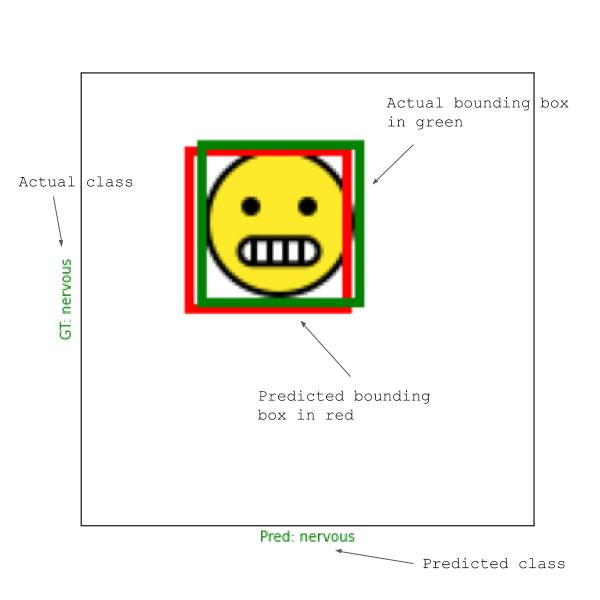

All emojis designed by [OpenMoji](https://openmoji.org/) – the open-source emoji and icon project. License: CC BY-SA 4.0

## Visualize Data

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Check if we are using TensorFlow 2.4')
print('Using TensorFlow version', tf.__version__)

Check if we are using TensorFlow 2.4
Using TensorFlow version 2.4.0


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Check if we are using TensorFlow 2.4')
print('Using TensorFlow version', tf.__version__)

Check if we are using TensorFlow 2.4
Using TensorFlow version 2.4.0


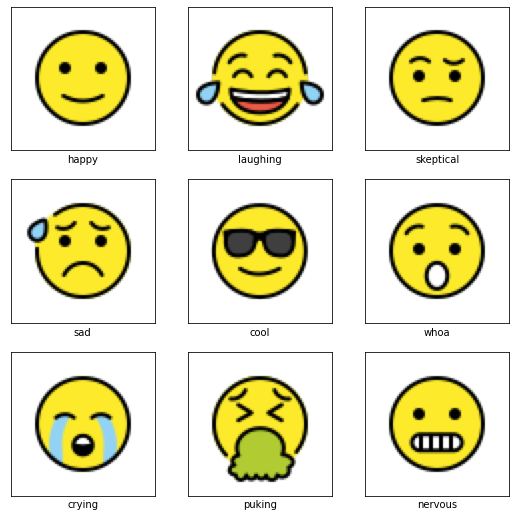

In [3]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    image=e['file']
    plt.imshow(plt.imread('emojis/{0}'.format(image)))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Create Examples

In [4]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [5]:
emojis

{0: {'name': 'happy',
  'file': '1F642.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x1A992D6C760>},
 1: {'name': 'laughing',
  'file': '1F602.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x1A992E50E80>},
 2: {'name': 'skeptical',
  'file': '1F928.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x1A992D40C70>},
 3: {'name': 'sad',
  'file': '1F630.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x1A9C989ADC0>},
 4: {'name': 'cool',
  'file': '1F60E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x1A992D40D00>},
 5: {'name': 'whoa',
  'file': '1F62F.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x1A9C99047C0>},
 6: {'name': 'crying',
  'file': '1F62D.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x1A9C99040A0>},
 7: {'name': 'puking',
  'file': '1F92E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x1A9C9904B20>},
 8: {'name': 'nervous',
  'file': '1F62C.pn

In [6]:
def create_example():
  class_id=np.random.randint(0,9)
  image=np.ones((144,144,3))*255
  row = np.random.randint(0,72)
  col =np.random.randint(0,72)
  image[row: row+72, col:col+72,:] = np.array(emojis[class_id]["image"])
  return image.astype('uint8'), class_id, (row +10)/144,(col+10)/144


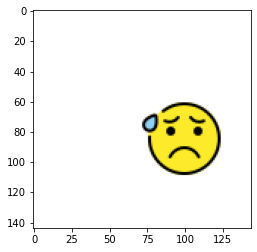

In [7]:
image, class_id,row,col=create_example()
plt.imshow(image)

## Plot Bounding Boxes

In [8]:
def plot_bounding_box(image, gt_coords, pred_coords=[] ,norm=False):
  if norm:
    image*=255.
    image =image.astype('uint8')
  image = Image.fromarray(image)
  draw=ImageDraw.Draw(image)

  row,col=gt_coords
  row *= 144
  col *=144
  draw.rectangle((col,row,col+52,row+52), outline='green',width=3)

  if len(pred_coords) ==2:
    row,col=pred_coords
    row*=144
    col*=144
    draw.rectangle((col,row,col+52,row+52),outline="red",width=3)
  return image


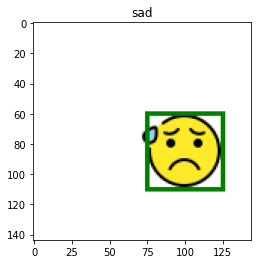

In [9]:
image = plot_bounding_box(image, gt_coords=[row,col])
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

## Data Generator

In [10]:
def data_generator(batch_size=16):
  while True:
    x_batch = np.zeros((batch_size,144,144,3))
    y_batch=np.zeros((batch_size,9))
    bbox_batch=np.zeros((batch_size,2))

    for i in range(0,batch_size):
      image,class_id,row,col = create_example()
      x_batch[i]=image/255.
      y_batch[i,class_id]=1.0
      bbox_batch[i]=np.array([row,col])
    yield {"image" : x_batch}, {"class_out":y_batch, "box_out":bbox_batch}

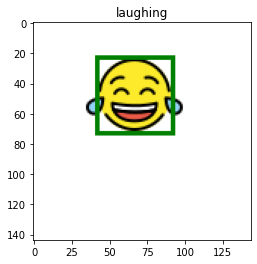

In [11]:
example,label=next(data_generator(1))
image=example["image"][0]
class_id=np.argmax(label["class_out"][0])
coords=label["box_out"][0]

image=plot_bounding_box(image ,coords, norm=True)
plt.imshow(image)
plt.title(emojis[class_id]["name"])
plt.show()


## Model

In [12]:
input_=Input(shape=[144,144,3],name='image')

x=input_

for i in range(0,5):
  n_filters=2**(4+i)
  x=Conv2D(n_filters,3,activation="relu")(x)
  x=BatchNormalization()(x)
  x=MaxPool2D(2)(x)

x=Flatten()(x)
x=Dense(256,activation='relu')(x)

class_out=Dense(9,activation="softmax", name="class_out")(x)
box_out=Dense(2,name="box_out")(x)

model=tf.keras.models.Model(input_,[class_out,box_out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 144, 144, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 142, 142, 16) 448         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 142, 142, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 71, 71, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Custom Metric: IoU

In [13]:
class IoU(tf.keras.metrics.Metric):
  def __init__(self, **kwargs):
    super(IoU,self).__init__(**kwargs)

    self.iou = self.add_weight(name="iou", initializer="zeros")
    self.total_iou = self.add_weight(name="total_iou", initializer="zeros")
    self.num_ex=self.add_weight(name="num_ex", initializer="zeros")

  def update_state(self,y_true, y_pred, sample_weight=None):
    def get_box(y):
      rows,cols=y[:,0], y[:,1]
      rows,cols = rows*144, cols*144
      y1, y2 = rows, rows+ 52
      x1, x2 = cols, cols +52
      return x1, y1, x2, y2

    def get_area(x1, y1, x2, y2):
      return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)

    gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
    p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)

    i_x1 = tf.maximum(gt_x1, p_x1)
    i_y1 = tf.maximum(gt_y1, p_y1)
    i_x2 = tf.minimum(gt_x2, p_x2)
    i_y2 = tf.minimum(gt_y2, p_y2)

    i_area = get_area(i_x1, i_y1, i_x2, i_y2)
    u_area= get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area

    iou=tf.math.divide(i_area, u_area)
    self.num_ex.assign_add(1)
    self.total_iou.assign_add(tf.reduce_mean(iou))
    self.iou =tf.math.divide(self.total_iou, self.num_ex)

  def result(self):
    return self.iou
  
  def reset_state(self):
    self.iou = self.add_weight(name="iou", initializer="zeros")
    self.total_iou = self.add_weight(name="total_iou", initializer="zeros")
    self.num_ex =self.add_weight(name="num_ex", initializer="zeros")




## Compile the Model

In [14]:
model.compile(
    loss={
        'class_out': "categorical_crossentropy",
        'box_out' : "mse"
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out':'accuracy',
        'box_out':IoU(name='iou')
    }
)

## Custom Callback: Model Testing

In [15]:
def test_model(model, test_datagen):
  example, label = next(test_datagen)
  x= example['image']
  y=label['class_out']
  box=label['box_out']

  pred_y, pred_box = model.predict(x)

  pred_coords = pred_box[0]
  gt_coords=box[0]
  pred_class = np.argmax(pred_y[0])
  image = x[0]

  gt = emojis[np.argmax(y[0])]['name']
  pred_class_name = emojis[pred_class]['name']

  image = plot_bounding_box(image, gt_coords, pred_coords, norm =True)
  color = "green" if gt ==pred_class_name else "red"


  plt.imshow(image)
  plt.xlabel(f'Pred:{pred_class_name}',color=color)
  plt.ylabel(f'GT: {gt}' , color=color)
  plt.xticks([])
  plt.yticks([])


In [16]:
def test(model):
  test_datagen = data_generator(1)

  plt.figure(figsize=(16,4))

  for i in range(0,6):
    plt.subplot(1,6,i+1)
    test_model(model,test_datagen)
  plt.show()

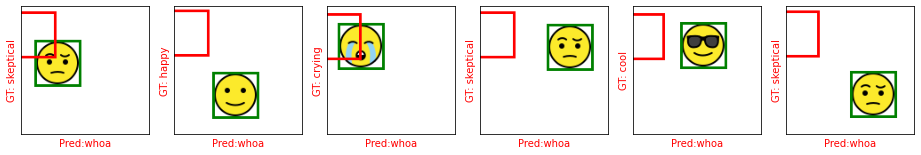

In [17]:
test(model)

In [18]:
class ShowTestImages(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    test(self.model)

## Model Training

Epoch 1/15
500/500 [==============================] - 200s 386ms/step - loss: 2.3990 - class_out_loss: 1.4305 - box_out_loss: 0.9685 - class_out_accuracy: 0.5102 - box_out_iou: 0.1333


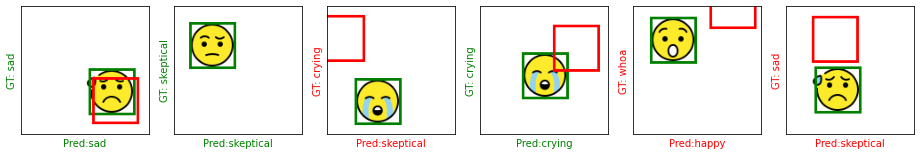

Epoch 2/15
500/500 [==============================] - 190s 380ms/step - loss: 0.0382 - class_out_loss: 0.0106 - box_out_loss: 0.0276 - class_out_accuracy: 0.9995 - box_out_iou: 0.3143


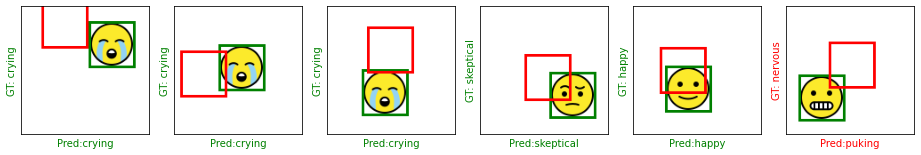

Epoch 3/15
500/500 [==============================] - 178s 356ms/step - loss: 0.0177 - class_out_loss: 0.0047 - box_out_loss: 0.0130 - class_out_accuracy: 0.9997 - box_out_iou: 0.4306


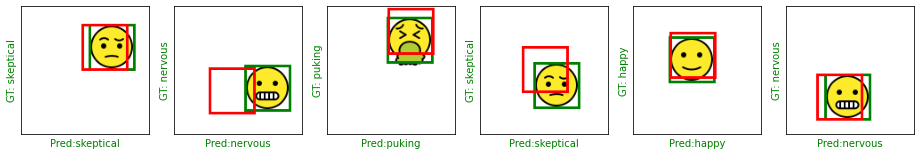

Epoch 4/15
500/500 [==============================] - 184s 367ms/step - loss: 0.0070 - class_out_loss: 0.0012 - box_out_loss: 0.0058 - class_out_accuracy: 1.0000 - box_out_iou: 0.5592


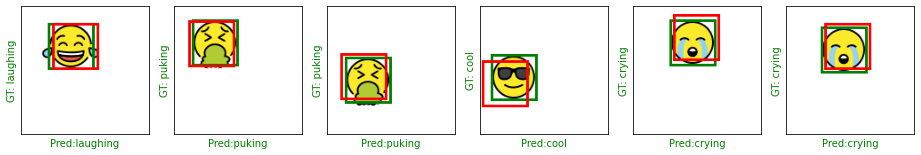

Epoch 5/15
500/500 [==============================] - 193s 387ms/step - loss: 0.0038 - class_out_loss: 0.0011 - box_out_loss: 0.0026 - class_out_accuracy: 1.0000 - box_out_iou: 0.6656


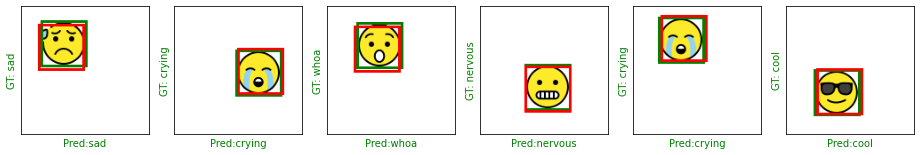

Epoch 6/15
500/500 [==============================] - 192s 384ms/step - loss: 0.0026 - class_out_loss: 5.5726e-04 - box_out_loss: 0.0020 - class_out_accuracy: 1.0000 - box_out_iou: 0.6968


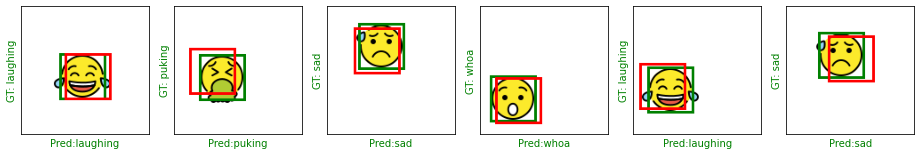

Epoch 7/15
500/500 [==============================] - 191s 382ms/step - loss: 0.0024 - class_out_loss: 4.4516e-04 - box_out_loss: 0.0019 - class_out_accuracy: 1.0000 - box_out_iou: 0.7064


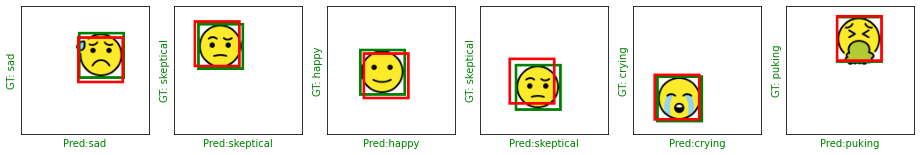

Epoch 8/15
500/500 [==============================] - 189s 379ms/step - loss: 0.0022 - class_out_loss: 4.3627e-04 - box_out_loss: 0.0018 - class_out_accuracy: 1.0000 - box_out_iou: 0.7119


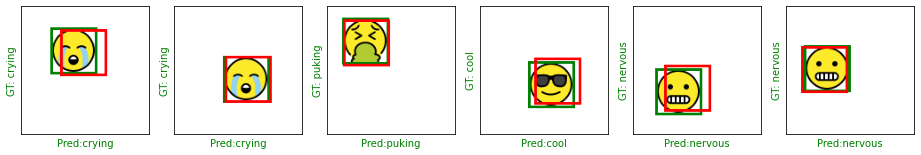

Epoch 9/15
500/500 [==============================] - 188s 376ms/step - loss: 0.0021 - class_out_loss: 3.5215e-04 - box_out_loss: 0.0017 - class_out_accuracy: 1.0000 - box_out_iou: 0.7166


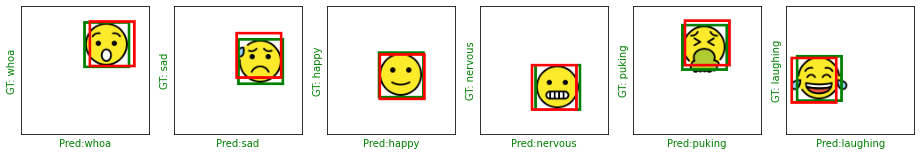

Epoch 10/15
500/500 [==============================] - 193s 387ms/step - loss: 0.0015 - class_out_loss: 2.9094e-04 - box_out_loss: 0.0012 - class_out_accuracy: 1.0000 - box_out_iou: 0.7536


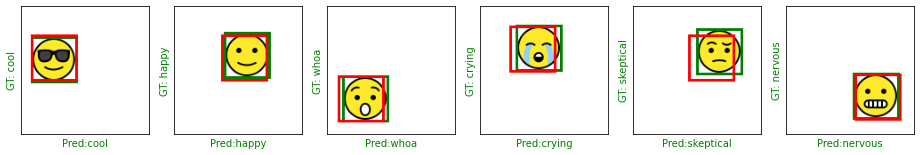

Epoch 11/15
500/500 [==============================] - 196s 393ms/step - loss: 0.0014 - class_out_loss: 2.8108e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7633


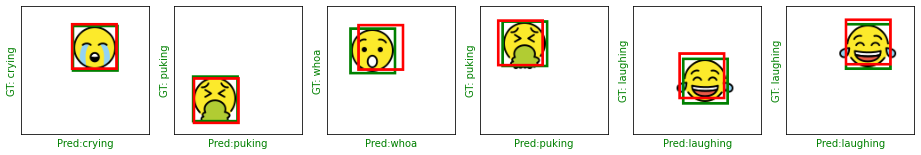

Epoch 12/15
500/500 [==============================] - 193s 387ms/step - loss: 0.0014 - class_out_loss: 2.6268e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7647


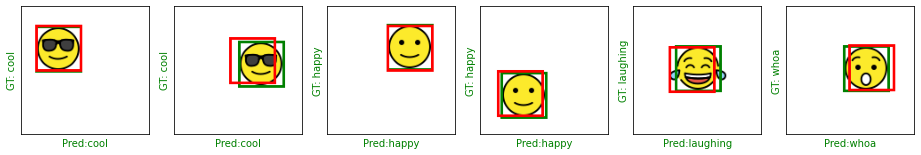

Epoch 13/15
500/500 [==============================] - 197s 393ms/step - loss: 0.0013 - class_out_loss: 2.3687e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7686


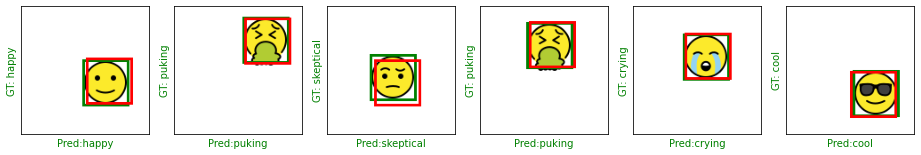

Epoch 14/15
500/500 [==============================] - 192s 385ms/step - loss: 0.0013 - class_out_loss: 2.3560e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7672


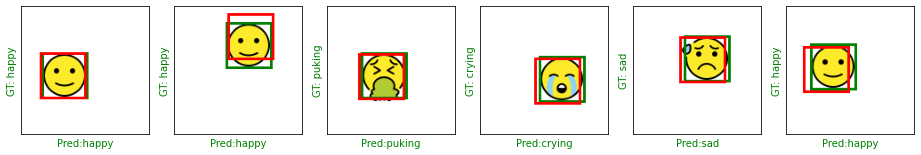

Epoch 15/15
500/500 [==============================] - 192s 384ms/step - loss: 0.0011 - class_out_loss: 2.2307e-04 - box_out_loss: 9.1525e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7822


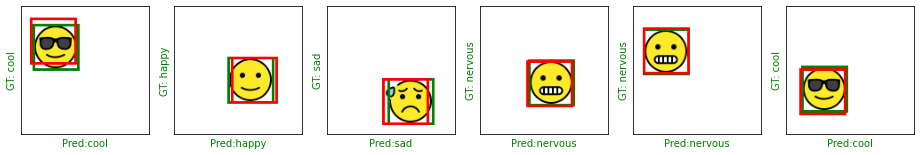

In [19]:
def lr_schedule(epoch,lr):
  if (epoch +1) % 5 == 0:
    lr*=0.2
  return max(lr, 3e-7)

_ = model.fit(
    data_generator(),
    epochs=15,
    steps_per_epoch=500,
    callbacks=[
              ShowTestImages(),
              tf.keras.callbacks.EarlyStopping(monitor="box_out_iou", patience=3, mode ="max"),
              tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)